In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
import os
import copy
import time
import csv

from agent import PPO
from env import Flowsheet
from Simulation import *

In [2]:
def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.plot(x,scores, alpha=0.2)
    plt.title('Running average of previous 100 scores')

c:\Users\m85830ak\Python\flowsheet-desing-main\.venv\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Error happened when reading data
Episode 1 total steps 7 avg score -1.6213
Error happened when reading data
Episode 2 total steps 19 avg score -2.1550
Error happened when reading data
Episode 3 total steps 24 avg score -2.1385
Error happened when reading data
Episode 4 total steps 39 avg score -2.3736
Error happened when reading data
Episode 5 total steps 45 avg score -2.2125
Error happened when reading data
Episode 6 total steps 51 avg score -2.2023
Episode 7 total steps 66 avg score -3.3730
Episode 8 total steps 76 avg score -4.2442
Episode 9 total steps 83 avg score -4.8698
Error happened when reading data
Episode 10 total steps 88 avg score -4.5712
Error happened when reading data
Episode 11 total steps 98 avg score -4.3695
Episode 12 total steps 104 avg score -4.8028
Error happened when reading data
Episode 13 total steps 111 avg score -4.5709
Error happened when reading data
Episode 14 total steps 116 avg score -4.3591
Error happened when reading data
Episode 15 total steps 122 a

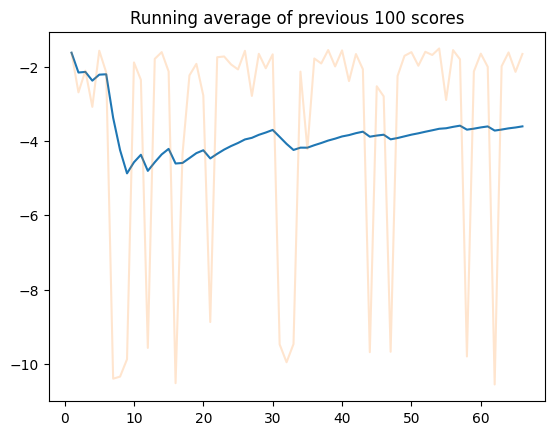

In [3]:
global sim, score_history

def main():
    global sim, score_history
    cwd = os.getcwd()
    sim = Simulation("DME_prod.bkp", cwd)


    env_kwargs = {
            "sim": sim,
            "pure": 0.99, 
            "max_iter": 15, 
            "inlet_specs": [25.0, 1, {"DME": 0, "WATER": 0.2*261.5, "METHANOL": 0.8*261.5}]
        }

    env = Flowsheet(**env_kwargs)

    random_seed = 50
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    env.seed(random_seed)
   

    # Hyperparameters
    kwargs = {
        "state_dim": env.observation_space.shape[0], 
        "actions": env.action_space, 
        "env_with_Dead": True,
        "gamma": 0.99, 
        "gae_lambda": 0.95, 
        "policy_clip": 0.2, 
        "n_epochs": 10, 
        "net_width": 64, 
        "lr": 2.5e-4, 
        "l2_reg": 0.5, 
        "batch_size": 64, 
        "entropy_coef": 0.025,
        "adv_normalization": True, 
        "entropy_coef_decay": 0.9
    }


    N = 512 # lenth of long trajectory
    Max_train_steps = int(50e1)
    best_interval = int(10e1)
    score_history = []

    total_steps = 0
    traj_length = 0
    episode = 1
    best_score = -100
    
    
    model = PPO(**kwargs)

    if not os.path.exists('model'): 
        os.mkdir('model')
    
    if not os.path.exists('best_model'): 
        os.mkdir('best_model')
    
    update = 0
    num_updates = Max_train_steps // N
    
    while total_steps < Max_train_steps:
        (observation, sin), done, steps, score = env.reset(), False, 0, 0
        mask_vec = env.action_masks(sin, True)

        '''Interact & trian'''
        while not done:
            steps += 1
            traj_length += 1
            total_steps += 1

            action_d, probs_d, action_c, probs_c = model.select_action(observation, mask_vec)
            action = {
                "discrete": action_d,
                "continuous": action_c}
            
            # Sometimes ASPEN bugs and fails to read information
            try:
                observation_, reward, done, info, sin = env.step(action, sin)

                if (done and steps != env.max_iter):
                    dw = True  #dw: dead and win
                else:
                    dw = False

                model.put_data((observation, action_d, action_c, reward, observation_, probs_d, probs_c, done, dw, mask_vec))
                observation = observation_
                mask_vec = env.action_masks(sin)
                score += reward       

                if traj_length % N == 0:
                    a,b,c = model.train()
                    traj_length = 0
                    update += 1
                    
                    frac = 1.0 - (update - 1.0) / num_updates
                    lrnow = frac * kwargs["lr"]
                    model.actor.optimizer.param_groups[0]["lr"] = lrnow
                    model.critic.optimizer.param_groups[0]["lr"] = lrnow

                    model.save(update)
            
            except:
                print("Error happened when reading data")
                done = True
                
        
        
        
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        # Save values of rewards
        f = open('rewards_file', 'a')
        writer = csv.writer(f, lineterminator = '\n')
        writer.writerow([avg_score])
        f.close()


        print('Episode {} total steps {} avg score {:.4f}'.
              format(episode, total_steps, avg_score))
        episode += 1

        ''' best model '''
        if total_steps >= best_interval:
            if score_history[-1] > best_score:
                best_score = score_history[-1]
                model.best_save()


    sim.CloseAspen() 

    
if __name__ == '__main__':
    start_time = time.time()
    try:
        main()
    except:
        print("Error")
        sim.CloseAspen()
    
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history)

    end_time = time.time()
    final_time = end_time - start_time
    print(final_time)